<a href="https://colab.research.google.com/github/JoungMinJu/lab_study/blob/main/11%EC%9E%A5_RNN%ED%85%8D%EC%8A%A4%ED%8A%B8%EB%B6%84%EB%A5%98/%EB%84%A4%EC%9D%B4%EB%B2%84_%EC%87%BC%ED%95%91%EB%A6%AC%EB%B7%B0_%EA%B0%90%EC%84%B1%EB%B6%84%EB%A5%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

이번에 사용할 데이터는 네이버 쇼핑 리뷰 데이터입니다. 총 200,000개 리뷰로 구성된 데이터로 평점이 5점 만점에 1, 2, 4, 5인 리뷰들로 구성된 데이터입니다. 3점인 리뷰는 긍부정 유무가 애매하여 데이터 구성 시에 제외되었습니다. 평점이 4, 5인 리뷰들에 긍정을 의미하는 레이블 1을, 평점이 1, 2인 리뷰들에 부정을 의미하는 레이블 0을 부여하고, 감성 분류를 수행하는 모델을 만들어보겠습니다.내

In [1]:
#형태소 분석기 Mecab을 사용하므로 코랩에 설치를 해야한다
# Colab에 Mecab 설치
!git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git
%cd Mecab-ko-for-Google-Colab
!bash install_mecab-ko_on_colab190912.sh

Cloning into 'Mecab-ko-for-Google-Colab'...
remote: Enumerating objects: 91, done.
remote: Counting objects: 100% (91/91), done.
remote: Compressing objects: 100% (85/85), done.
remote: Total 91 (delta 43), reused 22 (delta 6), pack-reused 0
Unpacking objects: 100% (91/91), done.
/content/Mecab-ko-for-Google-Colab
Installing konlpy.....
     |████████████████████████████████| 19.4 MB 1.3 MB/s 
     |████████████████████████████████| 448 kB 56.1 MB/s 
     |████████████████████████████████| 86 kB 5.7 MB/s 
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3
Done
Installing mecab-0.996-ko-0.9.2.tar.gz.....
from https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
--2021-08-20 00:59:54--  https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
Resolving bitbucket.org (bitbucket.org)... 104.192.141.1, 2406:da00:ff00

In [2]:
#네이버 쇼핑 리뷰 데이터에 대한 이해와 전처리
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from collections import Counter
from konlpy.tag import Mecab
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [3]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/bab2min/corpus/master/sentiment/naver_shopping.txt", filename="ratings_total.txt")

('ratings_total.txt', <http.client.HTTPMessage at 0x7f4bd34c6190>)

In [4]:
total_data = pd.read_table('ratings_total.txt', names=['ratings', 'reviews']) #해당 데이터에 열 제목이 별도로 없어서 임의로 두개의 열제목을 추가해줌
print('전체 리뷰 개수 :',len(total_data)) # 전체 리뷰 개수 출력

전체 리뷰 개수 : 200000


In [5]:
total_data[:5]

,ratings,reviews
0,5,배공빠르고 굿
1,2,택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고
2,5,아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 ...
3,2,선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전...
4,5,민트색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ


In [10]:
#훈련데이터와 테스트 데이터 분리
#평점 4,5-레이블1 // 평점 1,2 - 레이블 0

total_data['label']=np.select([total_data.ratings>3],[1],default=0)
total_data[:5]

,ratings,reviews,lable,label
0,5,배공빠르고 굿,1,1
1,2,택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고,0,0
2,5,아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 ...,1,1
3,2,선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전...,0,0
4,5,민트색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ,1,1


In [11]:
#중복을 제외함 샘플의 수를 카운트
total_data['ratings'].nunique(), total_data['reviews'].nunique(), total_data['label'].nunique()

(4, 199908, 2)

In [12]:
#ratings열은 1,2,4,5라는 네가지 값을 갖고 있다. reviews열에서 중복을 제외한 경우가 199,908개인데 현재 20만개 리뷰가 존재하므로 현재 갖고있는 데이터에 중복이 있다는 뜻
#중복을 제거해준다
total_data.drop_duplicates(subset=['reviews'],inplace=True)
print('총 샘플의 수 :',len(total_data))

총 샘플의 수 : 199908


In [13]:
print(total_data.isnull().values.any())

False


In [16]:
#훈련데이터 테스트 데이터 3:1비율로 분리
from sklearn.model_selection import train_test_split
train_data, test_data=train_test_split(total_data, test_size=0.25,random_state=42)
print('훈련용 리뷰의 개수 : ',len(train_data))
print('테스트용 리뷰의 개수 : ',len(test_data))

훈련용 리뷰의 개수 :  149931
테스트용 리뷰의 개수 :  49977


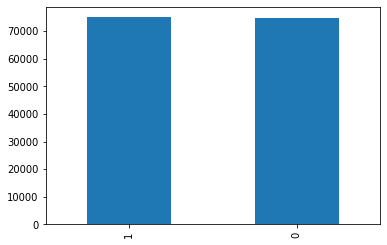

In [17]:
#레이블의 분포 확인
train_data['label'].value_counts().plot(kind='bar')


In [19]:
print(train_data.groupby('label').size().reset_index(name='count'))
#두 레이블의 분포 비율은 1:1

   label  count
0      0  74918
1      1  75013


In [20]:
#데이터 정제하기

#정규표현식을 사용하여 한글을 제외하고 모두  제거해주기
#그리고 이 과정에서 빈 샘플이 생기진 않는지 확인해주기
train_data['reviews']=train_data['reviews'].str.replace('[^ㄱ-ㅎㅏ-ㅣ가-힣]','')
train_data['reviews'].replace('',np.nan, inplace=True)
print(train_data.isnull().sum())

ratings    0
reviews    0
lable      0
label      0
dtype: int64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4582: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


In [21]:
#테스트 데이터도 같은 과정
test_data.drop_duplicates(subset = ['reviews'], inplace=True) # 중복 제거
test_data['reviews'] = test_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
test_data['reviews'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

전처리 후 테스트용 샘플의 개수 : 49977


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4582: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#r

In [22]:
#토큰화
mecab=Mecab()
print(mecab.morphs('와 이런 것도 상품이라고 차라리 내가 만드는 게 나을 뻔'))


['와', '이런', '것', '도', '상품', '이', '라고', '차라리', '내', '가', '만드', '는', '게', '나을', '뻔']


In [23]:
stopwords = ['도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를', '인', '듯', '과', '와', '네', '들', '듯', '지', '임', '게']

In [24]:
#훈련데이터 테스트데이터에 대해 토큰화작업
train_data['tokenized'] = train_data['reviews'].apply(mecab.morphs)
train_data['tokenized'] = train_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [25]:
test_data['tokenized'] = test_data['reviews'].apply(mecab.morphs)
test_data['tokenized'] = test_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

In [26]:
#단어와 길이 분포 확인하기

#긍정리뷰에는 주로 어떤 단어들이 많이 등장하고 부정리뷰에는 주로 어떤 단어가 등장하는지 빈도수 계산
negative_words = np.hstack(train_data[train_data.label == 0]['tokenized'].values)
positive_words = np.hstack(train_data[train_data.label == 1]['tokenized'].values)

In [27]:
#부정 리뷰에 ㄷ해 빈도수가 높은 상위 20개 단어 출력
negative_word_count = Counter(negative_words)
print(negative_word_count.most_common(20))

[('네요', 29687), ('는데', 19748), ('안', 18779), ('어요', 13799), ('있', 12927), ('너무', 12576), ('했', 11492), ('좋', 9463), ('배송', 9452), ('어', 8929), ('같', 8631), ('구매', 8540), ('거', 8379), ('없', 8264), ('습니다', 8209), ('되', 8130), ('아요', 8054), ('그냥', 7927), ('않', 7757), ('잘', 7576)]


In [28]:
#긍정도
positive_word_count = Counter(positive_words)
print(positive_word_count.most_common(20))

[('좋', 38612), ('아요', 20203), ('네요', 18965), ('잘', 18036), ('어요', 17891), ('구매', 15799), ('습니다', 13113), ('있', 12211), ('배송', 11939), ('는데', 11436), ('했', 9645), ('합니다', 9553), ('먹', 9457), ('재', 9064), ('너무', 8148), ('같', 7640), ('만족', 7071), ('어', 6628), ('아', 6531), ('거', 6261)]


긍정 리뷰의 평균 길이 :  13.22938690626958
부정 리뷰의 평균 길이 : 16.354534290824635


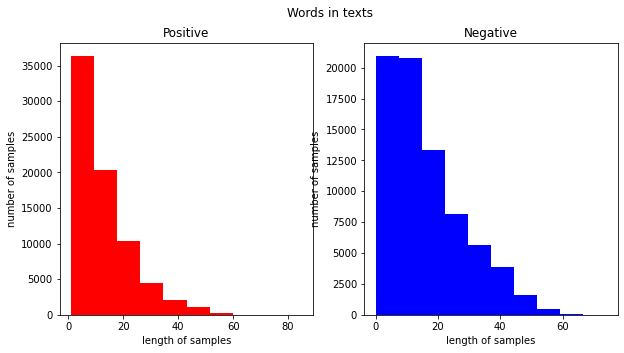

In [31]:
#두가지 경우에 대해서 각각 길이분포를 확인
fig, (ax1, ax2)=plt.subplots(1,2,figsize=(10,5))
text_len=train_data[train_data['label']==1]['tokenized'].map(lambda x: len(x))
ax1.hist(text_len, color='red')
ax1.set_title('Positive')
ax1.set_xlabel('length of samples')
ax1.set_ylabel('number of samples')
print('긍정 리뷰의 평균 길이 : ',np.mean(text_len))

text_len=train_data[train_data['label']==0]['tokenized'].map(lambda x: len(x))
ax2.hist(text_len, color='blue')
ax2.set_title('Negative')
fig.suptitle('Words in texts')
ax2.set_xlabel('length of samples')
ax2.set_ylabel('number of samples')
print('부정 리뷰의 평균 길이 :',np.mean(text_len))
plt.show()

#부정리뷰가 쩜 길게 작성됐네


In [32]:
 X_train = train_data['tokenized'].values
y_train = train_data['label'].values
X_test= test_data['tokenized'].values
y_test = test_data['label'].values

In [33]:
#정수 인코딩@

#우선 훈련 데이터에 대해서 단어집합을 만든다.
tokenizer=Tokenizer()
tokenizer.fit_on_texts(X_train)


In [34]:
#단어 집합이 생성되는 동시에 단어에 고유한 정수가 부여되었음
print(tokenizer.word_index)

{'네요': 1, '좋': 2, '어요': 3, '는데': 4, '아요': 5, '잘': 6, '있': 7, '구매': 8, '안': 9, '배송': 10, '습니다': 11, '했': 12, '너무': 13, '같': 14, '어': 15, '거': 16, '먹': 17, '합니다': 18, '되': 19, '재': 20, '기': 21, '않': 22, '쓰': 23, '아': 24, '없': 25, '것': 26, '요': 27, '해서': 28, '로': 29, '사용': 30, '았': 31, '으로': 32, '나': 33, '보다': 34, '만': 35, '었': 36, '지만': 37, '겠': 38, '해': 39, '아서': 40, '주': 41, '제품': 42, '보': 43, '그냥': 44, '어서': 45, '서': 46, '가격': 47, '면': 48, '만족': 49, '해요': 50, '좀': 51, '생각': 52, '주문': 53, '입니다': 54, '받': 55, '라': 56, '니': 57, '더': 58, '할': 59, '맛': 60, '많이': 61, '때': 62, '사이즈': 63, '시': 64, '에서': 65, '사': 66, '빠르': 67, '왔': 68, '샀': 69, '작': 70, '개': 71, '번': 72, '맛있': 73, '음': 74, '포장': 75, '별로': 76, '수': 77, '두': 78, '던': 79, '맞': 80, '입': 81, '저렴': 82, '괜찮': 83, '다른': 84, '상품': 85, '정말': 86, '세요': 87, '아니': 88, '하나': 89, '넘': 90, '데': 91, '냄새': 92, '에요': 93, '부분': 94, '못': 95, '아주': 96, '딱': 97, 'ㅠㅠ': 98, '감사': 99, '인데': 100, 'ㅎㅎ': 101, '용': 102, '으면': 103, '진짜': 104, '긴': 105, '보내'

In [35]:
#등장횟수가 1회인 단어들은 자연어 처리에서 배제할래

threshold=2
total_cnt=len(tokenizer.word_index) #단어의 수
rare_cnt=0 #등장빈도수가 2보다 작은 단어의 개수 카운트
total_freq=0 #훈련 데이터의 전체 단어 빈도수 총함
rare_freq=0 #등장 비도수가 2보다 작은 단어의 등장 빈도수의 총 합

#단어와 빈도수의 쌍을 key와 value로 받는다.
for key,value in tokenizer.word_counts.items():
  total_freq=total_freq+value
  #단어의 등장 빈도수가 2보다 작으면
  if(value<threshold):
    rare_cnt=rare_cnt+1
    rare_freq=rare_freq+value
print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 51331
등장 빈도가 1번 이하인 희귀 단어의 수: 27839
단어 집합에서 희귀 단어의 비율: 54.23428337651711
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 1.2553520094695902


In [36]:
# 전체 단어 개수 중 빈도수 2이하인 단어 개수는 제거.
# 0번 패딩 토큰과 1번 OOV 토큰을 고려하여 +2
vocab_size = total_cnt - rare_cnt + 2
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 23494


In [37]:
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV') #텍스트 시퀀스를 숫자 시퀀스로 변환하는데
#이러한 인코딩 과정에서 이보다 큰 숫자가 부여된 단어들은 OOV로 변환
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [38]:
print(X_test[:3m])

[[14, 690, 749, 112, 187, 246, 12], [334, 3869, 62, 4182, 1633], [11, 68, 2, 48, 156, 3, 27, 15, 6, 555, 285, 16, 90, 108, 589, 58, 7, 2]]


리뷰의 최대 길이 : 85
리뷰의 평균 길이 : 14.790970513102694


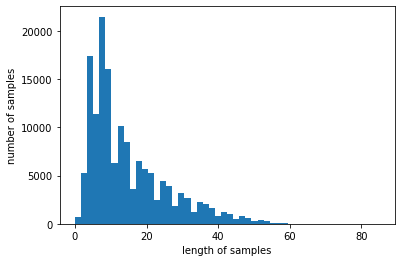

In [39]:
#패딩
print('리뷰의 최대 길이 :',max(len(l) for l in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [41]:
#전체적으로 60이하의 길이를 갖늗다

def below_threshold_len(max_len, nested_list):
  cnt=0
  for s in nested_list:
    if(len(s)<=max_len):
      cnt=cnt+1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율 :%s'%(max_len,(cnt/len(nested_list))*100))

In [42]:
#최대길이 85인데 만약 80으로 패딩하며 ㄴ몇개의 샘플을 온전히 보전할 수 있는지 확인
max_len=80
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 80 이하인 샘플의 비율 :99.99933302652553


In [43]:
X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

In [44]:
#GRU로 네이버 쇼핑 리뷰 감성분류하기

from tensorflow.keras.layers import Embedding,Dense,GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [45]:
model = Sequential()
model.add(Embedding(vocab_size, 100))
model.add(GRU(128))
model.add(Dense(1, activation='sigmoid'))

In [46]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [47]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=60, validation_split=0.2)

Epoch 1/15
2000/2000 [==============================] - 292s 145ms/step - loss: 0.2871 - acc: 0.8897 - val_loss: 0.2461 - val_acc: 0.9098

Epoch 00001: val_acc improved from -inf to 0.90976, saving model to best_model.h5
Epoch 2/15
2000/2000 [==============================] - 288s 144ms/step - loss: 0.2261 - acc: 0.9157 - val_loss: 0.2227 - val_acc: 0.9178

Epoch 00002: val_acc improved from 0.90976 to 0.91783, saving model to best_model.h5
Epoch 3/15
2000/2000 [==============================] - 287s 144ms/step - loss: 0.2089 - acc: 0.9223 - val_loss: 0.2268 - val_acc: 0.9136

Epoch 00003: val_acc did not improve from 0.91783
Epoch 4/15
2000/2000 [==============================] - 287s 144ms/step - loss: 0.1977 - acc: 0.9272 - val_loss: 0.2114 - val_acc: 0.9228

Epoch 00004: val_acc improved from 0.91783 to 0.92280, saving model to best_model.h5
Epoch 5/15
2000/2000 [==============================] - 288s 144ms/step - loss: 0.1871 - acc: 0.9321 - val_loss: 0.2156 - val_acc: 0.9204

Epo

In [48]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

1562/1562 [==============================] - 34s 21ms/step - loss: 0.2064 - acc: 0.9263

 테스트 정확도: 0.9263


리뷰예측해보기


In [59]:
def sentiment_predict(new_sentences):
  new_sentence=mecab.morphs(new_sentences)#토큰화
  new_sentence=[word for word in new_sentence if not word in stopwords]
  encoded=tokenizer.texts_to_sequences([new_sentence]) #정수 인코딩
  pad_new=pad_sequences(encoded, maxlen=max_len)#패딩
  score=float(loaded_model.predict(pad_new))#예측
  if(score>0.5):
    print("{:.2f}% 확률로 긍정 리뷰 입니다.".format(score*100))
  else:
    print("{:.2f}% 확률로 부정 리뷰 입니다.".format((1-score)*100))

In [60]:

sentiment_predict("이 상품 진짜 좋아요.. 저는 강추합니다. 대박")

97.55% 확률로 긍정 리뷰 입니다.


In [61]:
sentiment_predict("진짜 배송도 늦게 개짜즈아넨요. 뭐 이런 걸 상품이라고 만듬?")

97.45% 확률로 부정 리뷰 입니다.


In [62]:
sentiment_predict('판매자님... 너무 짱이에요.. 대박나삼')

97.98% 확률로 긍정 리뷰 입니다.


In [63]:
sentiment_predict('ㅁㄴㅇㄻㄴㅇㄻㄴㅇ리뷰쓰기도 귀찮아')

94.54% 확률로 부정 리뷰 입니다.
